## If the below cell doesn't run properly, you need to install all the requirements

In [4]:
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import csv
import random
from math import trunc
import matplotlib.pyplot as plt


### You want to be able to predict a given customer's response based on the current temperature.  

### After some initial data wrangling, you create a .csv file with a bunch of responses and temperatures:

In [25]:
with open("raw_data.csv", "r") as f:
    reader = csv.reader(f)
    sample_rows = [row for row in reader][:10]
sample_rows
    
    

[['response', 'temp'],
 ['too hot', '98'],
 ['too hot', '94'],
 ['too cold', '40'],
 ['too hot', '92'],
 ['too cold', '64'],
 ['too hot', '86'],
 ['too hot', '98'],
 ['just right', '67'],
 ['too cold', '50']]

### If you'd like, you can cheat and run the next cell to create your own "raw data":

In [26]:
def too_hot(): return {"response": "too hot", "temp": random.randrange(72,100)}
def just_right(): return {"response": "just right", "temp": random.randrange(65, 75)}
def too_cold(): return {"response": "too cold", "temp": random.randrange(40, 68)}

raw = [too_hot() for _ in range(300)] + [just_right() for _ in range(75)] + [too_cold() for _ in range(300)]

random.shuffle(raw)
random.shuffle(raw)
random.shuffle(raw)

with open("raw_data.csv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=["response", "temp"])
    writer.writeheader()
    writer.writerows(raw)


### Now that we have our basic dataset, we need to do a little bit of processing to make things easier on our model (the poor thing really only understands numbers...).  Convert the responses to numbers.  This conversion is arbitrary as long as you remember how to convert back (conveniently stored in `output_conversion_dict`).


In [27]:
output_conversion_dict = {
    1: "too hot",
    2: "just right",
    3: "too cold"
}

def convert(row):
    if row["response"] == "too hot": return [1, int(row["temp"])]
    if row["response"] == "just right": return [2, int(row["temp"])]
    if row["response"] == "too cold": return [3, int(row["temp"])]

def convert_response_to_int():
    with open("raw_data.csv", "r") as f:
        reader = csv.DictReader(f)
        converted = [convert(row) for row in reader]
    return converted

### At this point we have our cleaned and processed data (`prepared_data`).  We now need to do a couple things before we get to the model itself.


In [28]:
prepared_data = convert_response_to_int()
prepared_data[:10]

[[3, 57],
 [3, 55],
 [2, 67],
 [1, 84],
 [2, 72],
 [1, 74],
 [3, 59],
 [3, 60],
 [1, 74],
 [3, 45]]

# Train/Test Split

### We want to train our model, but we also want to have an easy way to test it out on data it hasn't seen.  There is a tension here in that we want to give our model as much data as possible so the model represents our problem domain as accurately as possible, but we also want some way to verify that our model actually extends to data that it hasn't seen yet.  For that reason we always split our data into a training set (usually 70-80%) and a test set (usually 20-30%).  This results in `train_samples` and `test_samples` . 


In [29]:
def get_train_test_split(samples):
    random.shuffle(samples)
    num_samples = len(samples)
    cutoff_index = trunc(.8 * num_samples)
    train_samples = samples[:cutoff_index]
    test_samples = samples[cutoff_index:]
    return train_samples, test_samples    

def get_samples(train_samples, test_samples):
    train_X = [[s[1]] for s in train_samples]
    train_Y = [s[0] for s in train_samples]
    test_x = [[s[1]] for s in test_samples]
    test_y = [s[0] for s in test_samples]
    return train_X, train_Y, test_x, test_y

train_samples, test_samples = get_train_test_split(prepared_data)


### In addition to that split into training and testing data, we also want to split each division into the input data and the correct outcome.  Confusingly, the convention for input data is `X`, and the corresponding correct outcome is `Y`.  This results in `train_X`, `train_Y`, `test_x`, `test_y` where the "x" is the temperature and the "y" is the (encoded) customer's response.

In [30]:
train_X, train_Y, test_x, test_y = get_samples(train_samples, test_samples)


### Now that we have all our data ready to go, let's move on to the easy part.


# Training the Model

### There are many options for classification models.  You can, and should, play around with several when you are developing an app.  But for now we are going to use the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/tree.html).  

### Hopefully, looking at this snippet from the above documentation helps to justify everything we've just done:

In [23]:
### Example from the scikit-learn docs ###

from sklearn import tree
X = [[0, 0], [1, 1]]
Y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)


### In our case, `X` would be the temperatures (`train_X`):


In [33]:
train_X[:10]

[[55], [54], [93], [73], [51], [99], [77], [69], [82], [91]]

### and `Y` would be the encoded customer responses (`train_Y`):


In [34]:
train_Y[:10]

[3, 3, 1, 2, 3, 1, 1, 2, 1, 1]

### Notice that the input needs to be a matrix, while the outcomes need to be a flat list.

### Let's go ahead and train the model now.

In [35]:
model = DecisionTreeClassifier()
model.fit(train_X, train_Y)


DecisionTreeClassifier()

### Now that we have a trained model, we can try it out on out test set to make sure it's working

In [37]:
score = model.score(test_x, test_y)
score

0.9185185185185185

### If the accuracy score looks good (and not suspiciously too good), you can try it out on some new data

In [41]:
new_input = [[105]]
model_guess = model.predict(new_input)
output_conversion_dict[model_guess[0]]


'too hot'

### Don't expect perfection or anything, it's really just a bunch of if statements.

### One nice feature of the DecisionTreeClassifier, is that you can pretty easily see how it works internally:

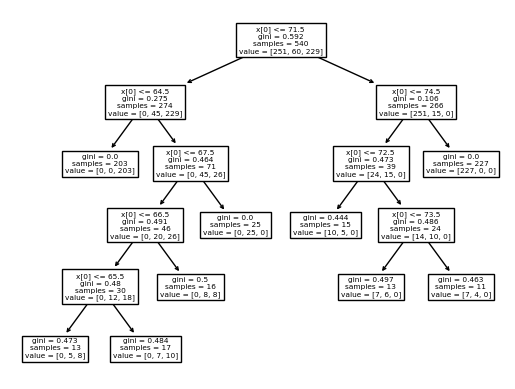

In [43]:
tree.plot_tree(model)
plt.show()